# GCN実装

論文：Semi-Supervised Classification with Graph Convolutional Networks
Thomas N. Kipf, Max Welling

ICLR 2017 https://arxiv.org/abs/1609.02907


参考コード：https://github.com/senadkurtisi/pytorch-GCN


**全体の流れ**

0.   事前にcora.contentとcora.citesをダウンロードして/content/drive/My Drive/Colab Notebooks/に置いてください．
1.   ライブラリのインストール
2.   GCNモデル定義 (NN実装がわかる人はここの参照のみで十分)
3.   グラフデータ読み込み
4.   学習準備
5.   モデル学習
6.   テスト精度検証
7.   結果の描画


# ライブラリのインストール

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import numpy as np
import scipy.sparse as sparse

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# モデル定義

GCN層を定義

In [ ]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features, use_bias=True):
        super(GCNLayer, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(torch.zeros(size=(in_features, out_features))))
        if use_bias:
            self.bias = nn.Parameter(torch.FloatTensor(torch.zeros(size=(out_features,))))
        else:
            self.register_parameter('bias', None)

        self.initialize_weights()

    def initialize_weights(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        x = x @ self.weight
        if self.bias is not None:
            x += self.bias

        return torch.sparse.mm(adj, x)

GCNモデルを定義．今回は2層のGCN．

In [ ]:
class GCN(nn.Module):
    def __init__(self, node_features, hidden_dim, num_classes, dropout, use_bias=True):
        super(GCN, self).__init__()
        self.gcn_1 = GCNLayer(node_features, hidden_dim, use_bias)
        self.gcn_2 = GCNLayer(hidden_dim, num_classes, use_bias)
        self.dropout = nn.Dropout(p=dropout)

    def initialize_weights(self):
        self.gcn_1.initialize_weights()
        self.gcn_2.initialize_weights()

    def forward(self, x, adj):
        x = F.relu(self.gcn_1(x, adj))
        x = self.dropout(x)
        x = self.gcn_2(x, adj)
        return x

他のモデルも定義可能．以下は1層のGCNモデル．

In [ ]:
class GCN1(nn.Module):
    def __init__(self, node_features, hidden_dim, num_classes, dropout, use_bias=True):
        super(GCN, self).__init__()
        self.gcn_1 = GCNLayer(node_features, hidden_dim, use_bias)

    def initialize_weights(self):
        self.gcn_1.initialize_weights()

    def forward(self, x, adj):
        x = self.gcn_1(x, adj)
        return x

# グラフデータ読み込み

各ノードの情報cora.contentを読み込み
データの内容を具体的に確認したい場合，print文のコメントアウトを外してください．


In [ ]:
print("Loading Cora dataset...")
raw_nodes_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.content', dtype="str")
print(raw_nodes_data)
raw_node_ids = raw_nodes_data[:, 0].astype('int32')  # 各行の一列目に格納されてるノードIDを抽出
#print(raw_node_ids)
raw_node_labels = raw_nodes_data[:, -1]# 各行の最終列に格納されてるラベルを抽出．このラベルが予測ターゲット
#print(raw_node_labels)

unique = list(set(raw_node_labels))
print(unique)
labels_enumerated = np.array([unique.index(label) for label in raw_node_labels])
print(labels_enumerated)
node_features = sparse.csr_matrix(raw_nodes_data[:, 1:-1], dtype="float32")
#print(node_features)


Loading Cora dataset...
[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']
 ...
 ['1128978' '0' '0' ... '0' '0' 'Genetic_Algorithms']
 ['117328' '0' '0' ... '0' '0' 'Case_Based']
 ['24043' '0' '0' ... '0' '0' 'Neural_Networks']]
['Theory', 'Probabilistic_Methods', 'Neural_Networks', 'Reinforcement_Learning', 'Case_Based', 'Rule_Learning', 'Genetic_Algorithms']
[2 5 3 ... 6 4 2]


グラフの枝情報を読み込み，隣接行列（adjacnecy matrix）を構築する．

In [ ]:
ids_ordered = {raw_id: order for order, raw_id in enumerate(raw_node_ids)} #実際のノードIDを0から節点数-1に対応付け
#print(ids_ordered)
raw_edges_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.cites', dtype="int32")
#print(raw_edges_data)
edges = np.array(list(map(ids_ordered.get, raw_edges_data.flatten())), dtype='int32').reshape(raw_edges_data.shape) # 実際のノードIDを変換. reshapeでデータ構造を元の枝ファイルと同様に変更．
#print(edges)

adj = sparse.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels_enumerated.shape[0], labels_enumerated.shape[0]),
                        dtype=np.float32)
#print(adj)

adj = adj + adj.T.multiply(adj.T > adj) #隣接行列を対象に変更 (つまり，無向グラフに変換)
#print(adj)

adj = adj + sparse.eye(adj.shape[0]) #対角成分に1を挿入

node_degrees = np.array(adj.sum(1)) #列毎の総和を計算する（つまり，次数を計算する）
#print(node_degrees)

node_degrees = np.power(node_degrees, -0.5).flatten()
#print(node_degrees)

degree_matrix = sparse.diags(node_degrees, dtype=np.float32)
print(degree_matrix)

adj = degree_matrix @ adj @ degree_matrix #行列の積を計算．
#torch.spmm(degree_matrix,torch.spmm(adj,degree_matrix))

print(adj)


  (0, 0)	0.4082483
  (1, 1)	0.70710677
  (2, 2)	0.4472136
  (3, 3)	0.5
  (4, 4)	0.70710677
  (5, 5)	0.57735026
  (6, 6)	0.57735026
  (7, 7)	0.70710677
  (8, 8)	0.4082483
  (9, 9)	0.4472136
  (10, 10)	0.4082483
  (11, 11)	0.57735026
  (12, 12)	0.57735026
  (13, 13)	0.5
  (14, 14)	0.2236068
  (15, 15)	0.30151135
  (16, 16)	0.4472136
  (17, 17)	0.70710677
  (18, 18)	0.35355338
  (19, 19)	0.57735026
  (20, 20)	0.4082483
  (21, 21)	0.4472136
  (22, 22)	0.4082483
  (23, 23)	0.57735026
  (24, 24)	0.57735026
  :	:
  (2683, 2683)	0.4472136
  (2684, 2684)	0.70710677
  (2685, 2685)	0.57735026
  (2686, 2686)	0.5
  (2687, 2687)	0.5
  (2688, 2688)	0.4472136
  (2689, 2689)	0.57735026
  (2690, 2690)	0.57735026
  (2691, 2691)	0.70710677
  (2692, 2692)	0.5
  (2693, 2693)	0.70710677
  (2694, 2694)	0.4472136
  (2695, 2695)	0.5
  (2696, 2696)	0.4472136
  (2697, 2697)	0.4472136
  (2698, 2698)	0.5
  (2699, 2699)	0.70710677
  (2700, 2700)	0.57735026
  (2701, 2701)	0.57735026
  (2702, 2702)	0.57735026
  (2703,

torch用に変換．

In [ ]:

features = torch.FloatTensor(node_features.toarray())
labels = torch.LongTensor(labels_enumerated)
adj = torch.FloatTensor(np.array(adj.todense()))


In [ ]:
print(features)
print(labels)
print(adj)
print(edges)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([2, 5, 3,  ..., 6, 4, 2])
tensor([[0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2500]])
[[ 163  402]
 [ 163  659]
 [ 163 1696]
 ...
 [1887 2258]
 [1902 1887]
 [ 837 1686]]


# 学習準備

訓練 (train data)，開発 (validation data)，検証データ(test data)の準備．
データの分割方法は様々な方法があるが，ここでは訓練データはラベル毎に固定数個を用いて，開発と検証データは残りからランダムに抽出．各データに**重複がない**ようにする必要がある．

In [ ]:
num_classes = int(labels.max().item() + 1) #ラベル数を定義．グラフでは，ラベルをクラスと言うことも多い．
train_size_per_class=20 #ラベル毎の訓練データ数．合計の訓練データ量は 7 * 20 = 140データ
validation_size=500 #開発データ数
test_size=1000 #テストデータ数
classes = [ind for ind in range(num_classes)]
train_set = []

# Construct train set (indices) out of 20 samples per each class
for class_label in classes:
    target_indices = torch.nonzero(labels == class_label, as_tuple=False).tolist() #ラベルがclass_labelsであるデータを抽出
    train_set += [ind[0] for ind in target_indices[:train_size_per_class]] #先頭からtrain_size_per_classまでのデータのインデックスを追加


# Extract the remaining samples
validation_test_set = [ind for ind in range(len(labels)) if ind not in train_set] #訓練データに含まれていないデータのインデックスを抽出
# Split the remaining samples into validation/test set
validation_set = validation_test_set[:validation_size] #先頭からvalidation_size番目までのデータのインデックスを開発データとして抽出
test_set = validation_test_set[validation_size:validation_size+test_size] #validation_sizeからvalidation_size+test_size番目までのデータのインデックスを検証データとして抽出

モデルの設定．

In [ ]:
dropout=0.2
use_bias=False
hidden_dim=32
model = GCN(features.shape[1], hidden_dim,num_classes, dropout, use_bias) #GCNのモデルを設定
#model = MLP(features.shape[1], hidden_dim,num_classes, dropout)

In [ ]:
if torch.cuda.is_available(): #cudaが使えるなら，GPUで処理
  model.cuda()
  adj = adj.cuda()
  features = features.cuda()
  labels = labels.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001) #learning rateとweight decayは適当に決定．
criterion = nn.CrossEntropyLoss()


精度計算用の関数

In [ ]:
def accuracy(output, labels):
    y_pred = output.max(1)[1].type_as(labels)
    correct = y_pred.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# モデル学習

In [ ]:
maxepoch=300
use_early_stopping=False
patience=30

validation_acc_list = []
validation_loss_list = []
train_acc_list=[]
train_loss_list=[]

if use_early_stopping:
    last_min_val_loss = float('inf')
    patience_counter = 0
    stopped_early = False

t_start = time.time()

for epoch in range(maxepoch):
    optimizer.zero_grad()
    model.train()

    y_pred = model(features, adj)

    train_loss = criterion(y_pred[train_set], labels[train_set])
    train_acc = accuracy(y_pred[train_set], labels[train_set])
    train_loss.backward()
    optimizer.step()

    train_loss_list.append(train_loss.item()) #train_lossはtorch tensor型なので，lossの値のみitem()で取得
    train_acc_list.append(train_acc.item())

    with torch.no_grad():
        model.eval()
        val_loss = criterion(y_pred[validation_set], labels[validation_set])
        val_acc = accuracy(y_pred[validation_set], labels[validation_set])

        validation_loss_list.append(val_loss.item())
        validation_acc_list.append(val_acc.item())

        if use_early_stopping:
            if val_loss < last_min_val_loss: #最小のlossを更新したら
                last_min_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter == patience: #最小のlossをpatience回連続で更新しなければ終了
                    stopped_early = True
                    t_end = time.time()

    if epoch%10 == 0: #10行毎に出力
      print(" | ".join([f"Epoch: {epoch:4d}", f"Train loss: {train_loss.item():.3f}",
                      f"Train acc: {train_acc:.2f}",
                      f"Val loss: {val_loss.item():.3f}",
                      f"Val acc: {val_acc:.2f}"]))

    if use_early_stopping and stopped_early:
        break

if use_early_stopping and stopped_early:
    print(f"EARLY STOPPING condition met. Stopped at epoch: {epoch}.")
else:
    t_end = time.time()

print(f"Total training time: {t_end-t_start:.2f} seconds")

Epoch:    0 | Train loss: 1.951 | Train acc: 0.19 | Val loss: 1.955 | Val acc: 0.14
Epoch:   10 | Train loss: 1.931 | Train acc: 0.26 | Val loss: 1.946 | Val acc: 0.15
Epoch:   20 | Train loss: 1.909 | Train acc: 0.34 | Val loss: 1.937 | Val acc: 0.23
Epoch:   30 | Train loss: 1.894 | Train acc: 0.47 | Val loss: 1.925 | Val acc: 0.31
Epoch:   40 | Train loss: 1.866 | Train acc: 0.57 | Val loss: 1.910 | Val acc: 0.39
Epoch:   50 | Train loss: 1.851 | Train acc: 0.63 | Val loss: 1.900 | Val acc: 0.43
Epoch:   60 | Train loss: 1.822 | Train acc: 0.73 | Val loss: 1.887 | Val acc: 0.47
Epoch:   70 | Train loss: 1.795 | Train acc: 0.78 | Val loss: 1.870 | Val acc: 0.52
Epoch:   80 | Train loss: 1.767 | Train acc: 0.81 | Val loss: 1.851 | Val acc: 0.57
Epoch:   90 | Train loss: 1.743 | Train acc: 0.82 | Val loss: 1.835 | Val acc: 0.57
Epoch:  100 | Train loss: 1.710 | Train acc: 0.83 | Val loss: 1.812 | Val acc: 0.61
Epoch:  110 | Train loss: 1.681 | Train acc: 0.86 | Val loss: 1.794 | Val ac

# テスト精度の検証

In [ ]:
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    model.eval()
    y_pred = model(features, adj)
    test_loss = criterion(y_pred[test_set], labels[test_set])
    test_acc = accuracy(y_pred[test_set], labels[test_set])

print(f"Test loss: {test_loss:.3f}  |  Test acc: {test_acc:.2f}")

Test loss: 1.474  |  Test acc: 0.74


# 結果の描画

まずは，訓練データのロスと精度，開発データのロスと精度がエポック毎にどのように変化してるか見てみましょう．

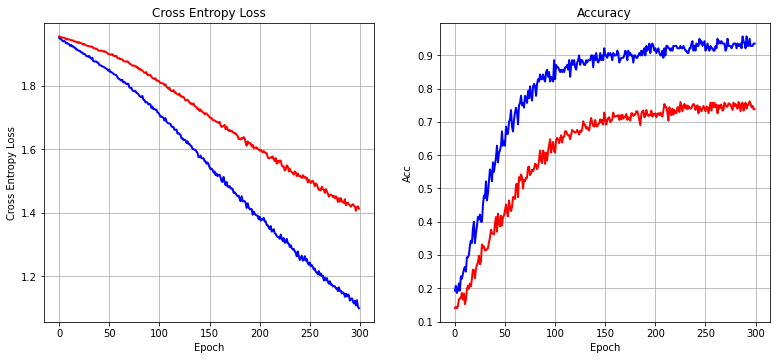

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(13, 5.5))
axs[0].plot(validation_loss_list, linewidth=2, color="red")
axs[0].plot(train_loss_list, linewidth=2, color="blue")
axs[0].set_title("Cross Entropy Loss")
axs[0].set_ylabel("Cross Entropy Loss")
axs[0].set_xlabel("Epoch")
axs[0].grid()

axs[1].plot(validation_acc_list, linewidth=2, color="red")
axs[1].plot(train_acc_list, linewidth=2, color="blue")
axs[1].set_title("Accuracy")
axs[1].set_ylabel("Acc")
axs[1].set_xlabel("Epoch")
axs[1].grid()

plt.show()

学習後のfeatureがラベルごとにかたまっている見てみましょう．
ここでは，tSNEを用いて多次元データを2次元に落とし込んで可視化をします．

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


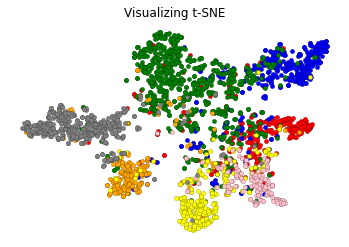

In [ ]:
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green",
                           3: "orange", 4: "yellow", 5: "pink", 6: "gray"} #識別性を高めるために，ラベルごとに色を固定化．coraのラベル数が7のため，0 から 6にそれぞれ色を割り当てる．


#%config InlineBackend.figure_format = 'retina' #画像の画質を向上したい場合，コメントアウト

node_labels = labels.cpu().numpy()
out_features = y_pred.cpu().numpy()
t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

plt.figure()
for class_id in range(num_classes):
    plt.scatter(t_sne_embeddings[node_labels == class_id, 0],
                t_sne_embeddings[node_labels == class_id, 1], s=20,
                color=cora_label_to_color_map[class_id],
                edgecolors='black', linewidths=0.15)

plt.axis("off")
plt.title("Visualizing t-SNE")
plt.show()

# 課題

**1. GCNではなくMLPをモデルとするように変更してください．**

2層のMLPモデルは下記になります．埋め込んでみましょう．

In [ ]:
class MLP (nn.Module):
    def __init__(self, node_features, hidden_dim, num_classes, dropout):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(node_features, hidden_dim)   
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout1 = nn.Dropout2d(dropout)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        return F.relu(self.fc2(x))

MLPをモデルとして設定して，呼び出してみましょう．下記を適切な場所に埋め込んでください．

In [ ]:
model = MLP(features.shape[1], hidden_dim,num_classes, dropout)
y_pred = model(features, adj)

TypeError: ignored

MLPとGCNの精度を比較して，隣接節点の情報を使うとどのくらい精度が上がるのか確認しましょう．

**2. GCN layerの総数を1から4に変更して，予測精度の変化を確認してください．**



class GCN(nn.Module)を変更するだけで，総数を変更できます．

**3. t-SNEの可視化を10エポック毎に行い，featureの変化を確認してください．その際，t-SNEの可視化処理を関数化するとわかりやすいです．**

下記の関数を活用して，可視化を行いましょう．

In [ ]:
def visualize_embedding_tSNE(labels, y_pred, num_classes):

    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    node_labels = labels.cpu().numpy()
    out_features = y_pred.detach().cpu().numpy()
    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_embeddings[node_labels == class_id, 0],
                    t_sne_embeddings[node_labels == class_id, 1], s=20,
                    color=cora_label_to_color_map[class_id],
                    edgecolors='black', linewidths=0.15)

    plt.axis("off")
    plt.title("Visualizing t-SNE")
    plt.show()